In [1]:
import matplotlib.pyplot as plt
import imageio
import glob
import random
import os
import numpy as np
import math
import itertools
import time
import datetime
import cv2
from pathlib import Path
from PIL import Image


from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch


In [2]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode='train'):
        self.transform = transforms.Compose(transforms_)

        self.files = sorted(glob.glob(os.path.join(root, mode) + '/*.*'))
        if mode == 'val':
            self.files.extend(sorted(glob.glob(os.path.join(root, 'val') + '/*.*')))

    def __getitem__(self, index):

        img = Image.open(self.files[index % len(self.files)])
        w, h = img.size
        img_A = img.crop((0, 0, w/2, h))
        img_B = img.crop((w/2, 0, w, h))

        if np.random.random() < 0.5:
            img_A = Image.fromarray(np.array(img_A)[:, ::-1, :], 'RGB')
            img_B = Image.fromarray(np.array(img_B)[:, ::-1, :], 'RGB')

        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        return img_A,img_B 

    def __len__(self):
        return len(self.files)

In [3]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

##############################
#           U-NET
##############################

class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [  nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
                    nn.InstanceNorm2d(out_size),
                    nn.ReLU(inplace=True)]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)


        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh()
        )


    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)


##############################
#        Discriminator
##############################

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels*2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [4]:
# parameters
epoch = 0 #  epoch to start training from
n_epoch = 200  #  number of epochs of training
batch_size =10  #  size of the batches
lr = 0.0002 #  adam: learning rate
b1 =0.5  #  adam: decay of first order momentum of gradient
b2 = 0.999  # adam: decay of first order momentum of gradient
decay_epoch = 100  # epoch from which to start lr decay
img_height = 256  # size of image height
img_width = 256  # size of image width
channels = 3  # number of image channels
sample_interval = 500 # interval between sampling of images from generators
checkpoint_interval = -1 # interval between model checkpoints

In [5]:
cuda = True if torch.cuda.is_available() else False

# Loss functions
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100

# Calculate output of image discriminator (PatchGAN)
patch = (1, img_height//2**4, img_width//2**4)

# Initialize generator and discriminator
generator = GeneratorUNet()
discriminator = Discriminator()

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    criterion_GAN.cuda()
    criterion_pixelwise.cuda()
    
# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [21]:
# Configure dataloaders
transforms_ = [ transforms.Resize((img_height, img_width), Image.BICUBIC),
                transforms.ToTensor()] # transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) 

dataloader = DataLoader(ImageDataset("facades1", transforms_=transforms_),
                        batch_size=16, shuffle=True)

val_dataloader = DataLoader(ImageDataset("facades1", transforms_=transforms_, mode='val'),
                            batch_size=8, shuffle=False)

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [7]:
def plot2x2Array(image, mask):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image)
    axarr[1].imshow(mask)

    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')

def reverse_transform(image):
    image = image.numpy().transpose((1, 2, 0))
    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)
    
    return image

In [8]:
def plot2x3Array(image, mask,predict):
    f, axarr = plt.subplots(1,3,figsize=(15,15))
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    axarr[2].imshow(predict)
    axarr[0].set_title('input')
    axarr[1].set_title('real')
    axarr[2].set_title('fake')

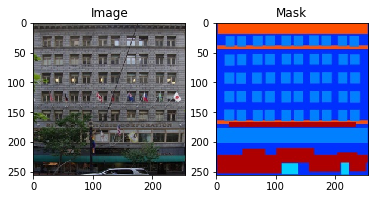

In [9]:
image, mask = next(iter(dataloader))
image = reverse_transform(image[0])
mask = reverse_transform(mask[0])
plot2x2Array(image, mask)

In [10]:
# ----------
#  Training
# ----------
losses = []
num_epochs = 200

# train the network
discriminator.train()
generator.train()
print_every = 400

for epoch in range(0, num_epochs):
    for i, batch in enumerate(dataloader):

        # Model inputs
        real_A = Variable(batch[0].type(Tensor))
        real_B = Variable(batch[1].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_B.size(0), *patch))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_B.size(0), *patch))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # GAN loss
        fake_A = generator(real_B)
        pred_fake = discriminator(fake_A, real_B)
        loss_GAN = criterion_GAN(pred_fake, valid)
        # Pixel-wise loss
        loss_pixel = criterion_pixelwise(fake_A, real_A)

        # Total loss
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        loss_G.backward()

        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator(real_A, real_B)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(fake_A.detach(), real_B)
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()
        
        # Print some loss stats
        if i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, loss_D.item(), loss_G.item()))
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((loss_D.item(), loss_G.item()))    


C:\Users\Ahmed SH\Anaconda3\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Epoch [    1/  200] | d_loss: 1.5389 | g_loss: 55.0410
Epoch [    2/  200] | d_loss: 0.4706 | g_loss: 19.3724
Epoch [    3/  200] | d_loss: 0.3148 | g_loss: 20.1476
Epoch [    4/  200] | d_loss: 0.2539 | g_loss: 18.0753
Epoch [    5/  200] | d_loss: 0.1815 | g_loss: 17.4888
Epoch [    6/  200] | d_loss: 0.1902 | g_loss: 17.5899
Epoch [    7/  200] | d_loss: 0.1465 | g_loss: 17.4338
Epoch [    8/  200] | d_loss: 0.1399 | g_loss: 18.4420
Epoch [    9/  200] | d_loss: 0.0874 | g_loss: 18.2274
Epoch [   10/  200] | d_loss: 0.1104 | g_loss: 18.9937
Epoch [   11/  200] | d_loss: 0.1797 | g_loss: 17.6549
Epoch [   12/  200] | d_loss: 0.1169 | g_loss: 18.2136
Epoch [   13/  200] | d_loss: 0.0989 | g_loss: 18.3002
Epoch [   14/  200] | d_loss: 0.0914 | g_loss: 18.0924
Epoch [   15/  200] | d_loss: 0.1300 | g_loss: 16.7378
Epoch [   16/  200] | d_loss: 0.1107 | g_loss: 16.7542
Epoch [   17/  200] | d_loss: 0.1515 | g_loss: 16.8972
Epoch [   18/  200] | d_loss: 0.1062 | g_loss: 17.2401
Epoch [   

Epoch [  149/  200] | d_loss: 0.0570 | g_loss: 10.7694
Epoch [  150/  200] | d_loss: 0.0559 | g_loss: 11.2846
Epoch [  151/  200] | d_loss: 0.0701 | g_loss: 11.0986
Epoch [  152/  200] | d_loss: 0.0596 | g_loss: 11.0936
Epoch [  153/  200] | d_loss: 0.0765 | g_loss: 10.3230
Epoch [  154/  200] | d_loss: 0.0617 | g_loss: 10.7748
Epoch [  155/  200] | d_loss: 0.0567 | g_loss: 11.1306
Epoch [  156/  200] | d_loss: 0.1396 | g_loss: 10.3803
Epoch [  157/  200] | d_loss: 0.0645 | g_loss: 10.9403
Epoch [  158/  200] | d_loss: 0.0628 | g_loss: 10.8123
Epoch [  159/  200] | d_loss: 0.0748 | g_loss: 10.1891
Epoch [  160/  200] | d_loss: 0.0661 | g_loss: 9.9728
Epoch [  161/  200] | d_loss: 0.2002 | g_loss: 11.3520
Epoch [  162/  200] | d_loss: 0.0438 | g_loss: 11.3330
Epoch [  163/  200] | d_loss: 0.0494 | g_loss: 10.3305
Epoch [  164/  200] | d_loss: 0.0560 | g_loss: 11.0432
Epoch [  165/  200] | d_loss: 0.0679 | g_loss: 10.7106
Epoch [  166/  200] | d_loss: 0.0870 | g_loss: 11.6361
Epoch [  16

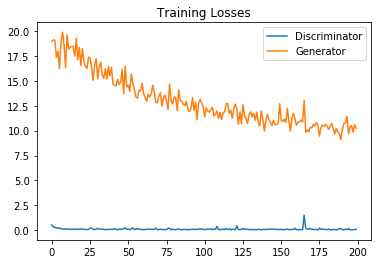

In [11]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

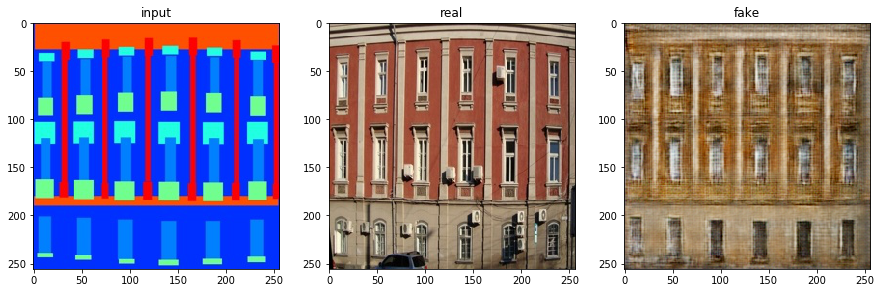

In [23]:
generator.eval()
image, mask = next(iter(dataloader))
output = generator(mask.type(Tensor))
output = output.view(16, 3, 256, 256)
output = output.cpu().detach()
image = reverse_transform(image[0])
output = reverse_transform(output[0])
mask = reverse_transform(mask[0])
plot2x3Array(mask,image,output)

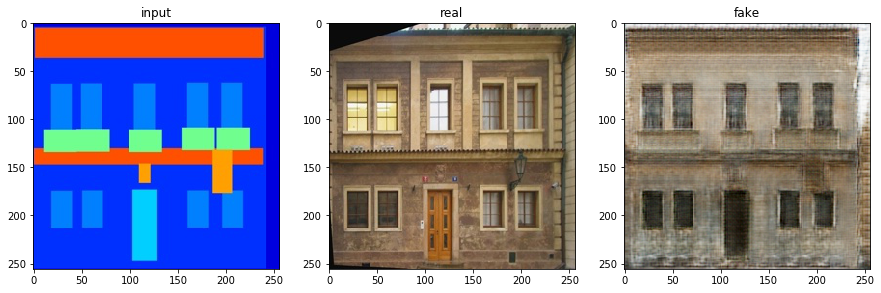

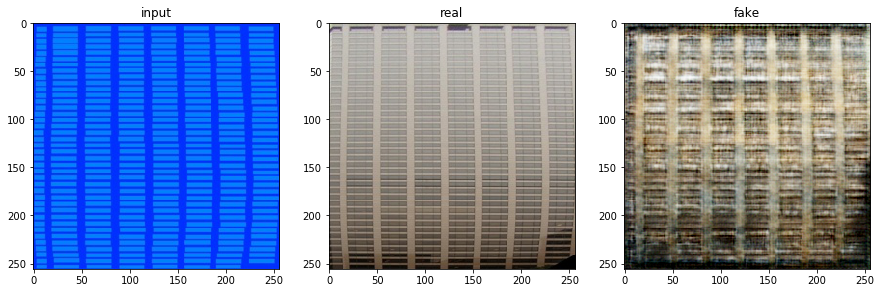

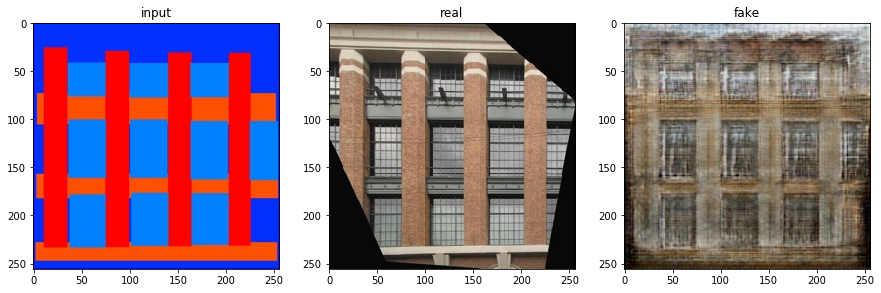

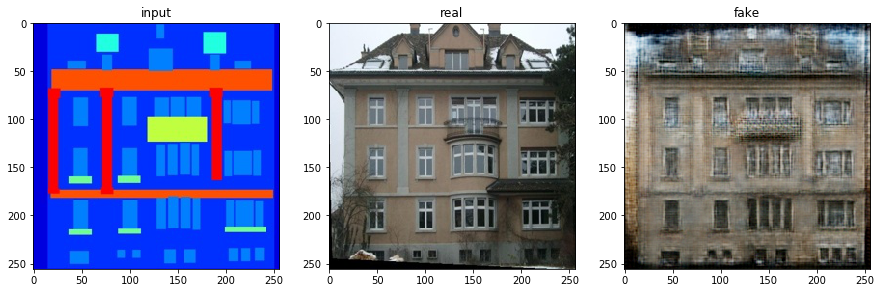

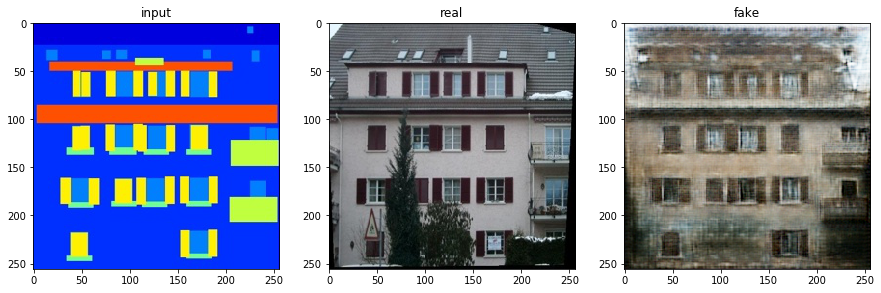

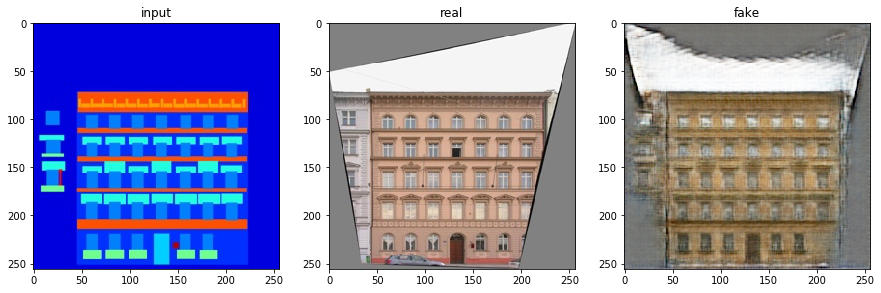

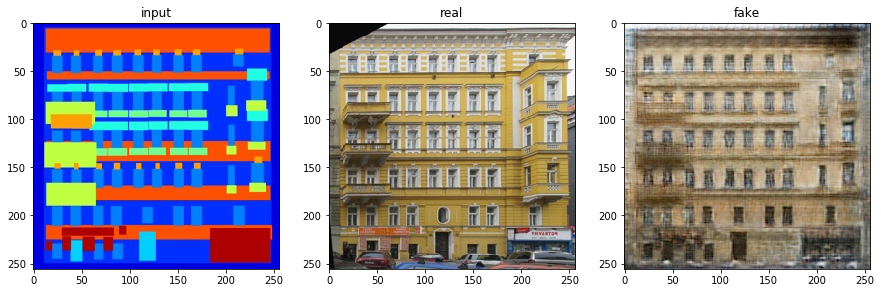

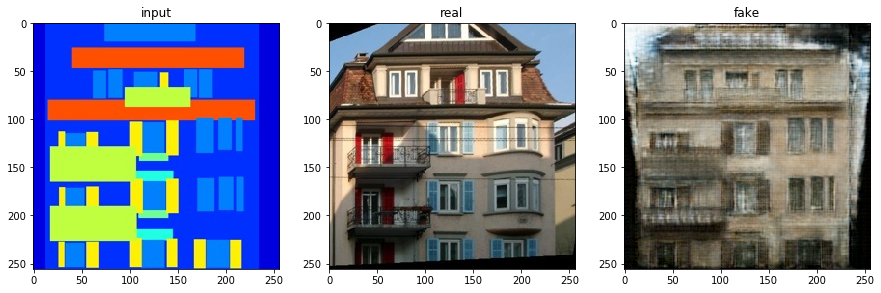

In [20]:
for i in range(8) :
    image, mask = next(iter(val_dataloader))
    output = generator(mask.type(Tensor))
    output = output.view(8, 3, 256, 256)
    output = output.cpu().detach()
    image = reverse_transform(image[i])
    output = reverse_transform(output[i])
    mask = reverse_transform(mask[i])
    plot2x3Array(mask,image,output)

In [13]:
torch.cuda.empty_cache()